<a href="https://colab.research.google.com/github/pe44enka/Yelp/blob/master/DA_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Yelp Analysis





---

My data came from Yelp Dataset. It was originally put together for the Yelp Dataset Challenge and then was able on Kaggle. It consists 5 json-files with more than 5M reviews, 174k businesses and spans 11 metropolitan areas. So it was too huge for student project, that's why I decided to use sample of this dataset covered just one region - Cleveland, Ohio (found on GitHub), and then I collected  all info I want to use for my analysis out of 5 json-files into one table (by using SQL) and uploaded it to my GitHub for easy access from colab notebook.



---

I intended to find out the key for successuful business: 
1. what kind of companies are most rated and most high/low rated
2. whether ratings and reviews influent on business shutdowns
3. what is the most common business hours for companies
4. how people preferences and opinions change over time
5. whether any difference between male and female ratings and in case it is what the target audience is for each kind of business 
6. whether any other relationship between different features of the data which we can use to improve business

---



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

from pandas.io.json import json_normalize
import urllib.request
import json

import random 
from nltk.corpus import names 
import nltk

from scipy.cluster import hierarchy
from sklearn import decomposition, preprocessing, cluster, tree
from yellowbrick.cluster.silhouette import SilhouetteVisualizer

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Data Cleaning

## Loading data

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/pe44enka/Yelp/master/data/FINAL_yelp_dataset_cleveland.csv')
df.head()

,ID,BUSINESS_ID,COMPANY_NAME,CATEGORIES,IS_OPEN,COMPANY_STARS,COMPANY_REVIEWS,ADDRESS,NEIGHBORHOOD,CITY,STATE,POSTAL_CODE,LATITUDE,LONGITUDE,HOURS_MONDAY,HOURS_TUESDAY,HOURS_WEDNESDAY,HOURS_THURSDAY,HOURS_FRIDAY,HOURS_SATURDAY,HOURS_SUNDAY,ACCEPT_CREDIT_CARD,PARKING_GARAGE,PARKING_STREET,PARKING_VALIDATED,PARKING_LOT,PARKING_VALLET,PARKING_BIKE,REVIEW_ID,DATE_REVIEW,STARS,REVIEW,USEFUL_REVIEW,COOL_REVIEW,FUNNY_REVIEW,USER_ID,USER_NAME,REVIEWS_BY_USER,USER_AVERAGE_STAR,YELPING_USER_SINCE,ELITE_USER_SINCE,USEFUL_USER,COOL_USER,FUNNY_USER,USER_FANS,COMPLIMENT_COOL,COMPLIMENT_CUTE,COMPLIMENT_FUNNY,COMPLIMENT_HOT,COMPLIMENT_LIST,COMPLIMENT_MORE,COMPLIMENT_NOTE,COMPLIMENT_PHOTOS,COMPLIMENT_PLAIN,COMPLIMENT_PROFILE,COMPLIMENT_WRITER
0,1645,tulUhFYMvBkYHsjmn30A9w,Hot Sauce Williams Barbecue Restaurant,Restaurants,1,3.0,154,7815 Carnegie Ave,Fairfax,Cleveland,OH,44103.0,41.501728,-81.633927,11:00-21:00,11:00-21:00,11:00-21:00,11:00-21:00,11:00-21:00,12:00-0:00,11:00-21:00,True,False,False,False,True,False,True,RYHKUSUyPeaU38RytDtZww,2/2/13,2,"""I've been going to Hot Sauce Williams for the...",10,3,7,kEEx6yEf81i9Wk5Ww1q6GA,Samuel,86,3.42,18-04-2009,2013.0,88,14,32,1,4,0,4,3,0,0,0,0,2,0,5
1,1645,tulUhFYMvBkYHsjmn30A9w,Hot Sauce Williams Barbecue Restaurant,Restaurants,1,3.0,154,7815 Carnegie Ave,Fairfax,Cleveland,OH,44103.0,41.501728,-81.633927,11:00-21:00,11:00-21:00,11:00-21:00,11:00-21:00,11:00-21:00,12:00-0:00,11:00-21:00,True,False,False,False,True,False,True,yUeBnTvqPNB8Ay_5PS3kWg,3/6/09,2,"""My girlfriend and I been dying to try this pl...",3,3,3,Jyi0WJt0UfGdEg0grR38ZA,Sam,69,3.42,20-11-2008,2010.0,5,5,2,4,14,0,14,14,0,2,12,1,12,0,5
2,1645,tulUhFYMvBkYHsjmn30A9w,Hot Sauce Williams Barbecue Restaurant,Restaurants,1,3.0,154,7815 Carnegie Ave,Fairfax,Cleveland,OH,44103.0,41.501728,-81.633927,11:00-21:00,11:00-21:00,11:00-21:00,11:00-21:00,11:00-21:00,12:00-0:00,11:00-21:00,True,False,False,False,True,False,True,q0cL9c_IQPjaGFIA64COFA,1/4/15,1,Worst food I've ever had the laziest service. ...,0,0,0,RyixLoQmLZt5BWp6xJZ5uQ,Vince,7,4.43,23-10-2012,NaN,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3,1645,tulUhFYMvBkYHsjmn30A9w,Hot Sauce Williams Barbecue Restaurant,Restaurants,1,3.0,154,7815 Carnegie Ave,Fairfax,Cleveland,OH,44103.0,41.501728,-81.633927,11:00-21:00,11:00-21:00,11:00-21:00,11:00-21:00,11:00-21:00,12:00-0:00,11:00-21:00,True,False,False,False,True,False,True,tBtVsv9M__Zl4xqQ7xN9AQ,4/16/15,4,"""Hot Sauce Williams is a Cleveland institution...",2,0,0,3AC_liBwORA9w18CIrGxcQ,Doug,34,3.81,05-07-2013,NaN,10,6,7,2,0,0,0,0,0,0,1,0,0,0,0
4,325,Jdqg97lLo_qJlCqU9RjIEA,Dairy Queen,Restaurants,1,3.0,6,12980 W Sprague Rd,NaN,Cleveland,OH,44130.0,41.351026,-81.784108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,True,Bz5kR052DviDGQGV_q8VUQ,9/8/12,3,"""Dipped cone all the way! This location is tri...",1,1,1,j5yfS1QjGwNLQ0h4_wDyxg,Alexis,550,4.10,20-05-2008,2012.0,332,211,233,88,78,12,78,44,3,5,38,19,66,15,35


## Supporting functions



---

To make final function less and more readable I took all functions I use for processing my data out of it and put them all together:
1. func to limit list of categories
2. funcs to extract open and close hour
3. func for processing parking columns
4. func for sentimental analysis of reviews column
5. func to get a gender out of user name (together with training model used for it)
6. list of labels for putting each company to a bin based on number of reviews it has

---



In [0]:
#limit categories
def limit_categories(val):
  if val in ('Restaurants', 'Food', 'American (Traditional)', 'American (New)', 
             'Pizza', 'Breakfast & Brunch', 'Sandwiches', 'Seafood', 'Italian', 'Salad',
             'Mexican', 'Ice Cream & Frozen Yogurt', 'Coffee & Tea', 'Mediterranean',
             'Sushi Bars', 'Chinese', 'Soup', 'Bakeries', 'Thai', 'French', 
             'Asian Fusion', 'Burgers', 'Fast Food', 'Noodles', 'Diners', 'Vietnamese',
             'Japanese', 'Specialty Food', 'Caterers', 'Gluten-Free', 'Indian',
             'Steakhouses', 'Grocery', 'Vegetarian', 'Cajun/Creole','Delis',
             'Middle Eastern', 'Cambodian', 'Donuts', 'Cafes', 'Ethnic Food',
             'Tapas/Small Plates', 'Desserts', 'Barbeque', 'Southern', 'Brazilian', 
             'Lebanese', 'Bagels', 'Szechuan', 'Soul Food', 'Comford Food','Salvadoran',
             'Vegan', 'Mongolian', 'Irish', 'Tea Rooms','Buffets', 'Chicken Wings',
             'Comfort Food', 'Juice Bars & Smoothies', 'Greek', 'Gastropubs',
             'British', 'Korean', 'Cuban', 'Cupcakes', 'Caribbean','Food Stands',
             'Tacos','Creperies'):
    return ('restaurants')
  elif val in ('Bars', 'Nightlife', 'Breweries', 'Lounges', 'Pubs', 'Cocktail Bars', 
               'Wine Bars', 'Beer', 'Beer Bar', 'Dance Clubs', 'Sports Bars', 
               'Dive Bars', 'Beer Gardens'):
    return('bars')
  elif val in ('Beauty & Spas', 'Polish', 'Hair Salons', 'Nail Salons', 'Hair Removal',
                  'Barbers', 'Day Spas', 'Hair Stylists'):
    return('beauty_spa')
  elif val in ('Hotels & Travel', 'Hotels', 'Airports','Car Rental', 'Transportation',
               'Resorts', 'Airlines'):
    return('travel')
  elif val in ('Public Services & Government', 'Local Services', 'Education', 'Home Services'):
    return('public_service')
  elif val in ('Arts & Entertainment', 'Event Planning & Services', 'Venues & Event Spaces', 
               'Shopping', 'Active Life', 'Adult Entertainment', 'Museums', 'Stadiums & Arenas',
               'Fashion', 'Music & DVDs', 'Music Venues', 'Cinema', 'Gyms', 'Art Galleries',
               'Fitness & Instruction', 'Aquariums', 'Performing Arts', "Women's Clothing",
               'Yoga','Shopping Centers', 'Party & Event Planning', 'Wedding Planning', 
               'Festivals'):
    return('entertainment')
  return 'other'

#extract open hour
def open_hours(ser):
  return ser.str.split(':',1, expand = True).iloc[:,0].fillna('-1').astype(int)

#extract close hour
def close_hours(ser):
  return ser.str.split('-',1, expand = True).iloc[:,1].str.split(':', expand=True).iloc[:,0].fillna('-1').astype(int)

#processing all park columns
def parking(ser):
  return ser.fillna('-1').astype(int)

#sentiment analysis of reviews
positive_word, negative_word = [], []
with urllib.request.urlopen('https://raw.githubusercontent.com/pe44enka/Yelp/master/data/positive.txt') as url:
  for line in url:
    positive_word.append(url.readline().decode()[:-2])
with urllib.request.urlopen('https://raw.githubusercontent.com/pe44enka/Yelp/master/data/negative.txt') as url:
  for line in url:
    negative_word.append(url.readline().decode()[:-1])
def sent_analysis(val):
  negative = positive = 0
  for word in val.split():
    if word in negative_word:
      negative += 1 
    elif word in positive_word:
      positive += 1
  if negative > positive:
    return 'negative'
  elif negative < positive:
    return 'positive'
  else:
    return 'neutral'

#extracting gender from name of user by training a model
male, female = [], []
with urllib.request.urlopen('https://raw.githubusercontent.com/pe44enka/Yelp/master/data/male.txt') as url:
  for line in url:
    male.append(line.decode()[:-1])
with urllib.request.urlopen('https://raw.githubusercontent.com/pe44enka/Yelp/master/data/female.txt') as url:
  for line in url:
    female.append(line.decode()[:-1])
def gender_features(word): 
    return {'last_letter':word[-1]} 
labeled_names = ([(name, 'male') for name in male]+ [(name, 'female') for name in female])
random.shuffle(labeled_names) 
featuresets = [(gender_features(n), gender)  
               for (n, gender)in labeled_names] 
train_set, test_set = featuresets[500:], featuresets[:500]
classifier = nltk.NaiveBayesClassifier.train(train_set)
def gender_classifier(val):
  return classifier.classify(gender_features(val))

## Final function

In [56]:
def final_func(df):
  q1 = df.REVIEW.apply(sent_analysis).rename('review')
  q2 = df.STARS.rename('stars')
  q3 = df.USER_NAME.dropna().apply(gender_classifier).rename('user_gender')
  q4 = pd.to_datetime(df.DATE_REVIEW).dt.year.rename('year')
  q5 = pd.to_datetime(df.DATE_REVIEW).dt.month.rename('month')
  q6 = pd.to_datetime(df.DATE_REVIEW).dt.day_name().rename('weekday')
  q7 = df.CATEGORIES.apply(limit_categories).rename('category')
  q8 = df.COMPANY_STARS.rename('company_star')
  q9 = df.COMPANY_REVIEWS.rename('company_review')
  q10 = df.IS_OPEN.rename('is_open')
  q11 = df.ACCEPT_CREDIT_CARD.fillna('-1').astype(int).rename('accept_credit_card')
  q12 = open_hours(df.HOURS_MONDAY).rename('mon_open')
  q13 = close_hours(df.HOURS_MONDAY).rename('mon_close')
  q14 = open_hours(df.HOURS_TUESDAY).rename('tue_open')
  q15 = close_hours(df.HOURS_TUESDAY).rename('tue_close')
  q16 = open_hours(df.HOURS_WEDNESDAY).rename('wed_open')
  q17 = close_hours(df.HOURS_WEDNESDAY).rename('wed_close')
  q18 = open_hours(df.HOURS_THURSDAY).rename('thu_open')
  q19 = close_hours(df.HOURS_THURSDAY).rename('thu_close')
  q20 = open_hours(df.HOURS_FRIDAY).rename('fri_open')
  q21 = close_hours(df.HOURS_FRIDAY).rename('fri_close')
  q22 = open_hours(df.HOURS_SATURDAY).rename('sat_open')
  q23 = close_hours(df.HOURS_SATURDAY).rename('sat_close')
  q24 = open_hours(df.HOURS_SUNDAY).rename('sun_open')
  q25 = close_hours(df.HOURS_SUNDAY).rename('sun_close')
  q26 = parking(df.PARKING_GARAGE).rename('park_garage')
  q27 = parking(df.PARKING_STREET).rename('park_street')
  q28 = parking(df.PARKING_LOT).rename('park_lot')
  q29 = parking(df.PARKING_VALIDATED).rename('park_valid')
  q30 = parking(df.PARKING_VALLET).rename('park_vallet')
  q31 = parking(df.PARKING_BIKE).rename('park_bike')

  return pd.concat([q1, q2, q3, q4, q5, q6, q7, q8, q9, q10, q11, q12, q13, 
                      q14, q15, q16, q17, q18, q19, q20, q21, q22, q23, q24, 
                      q25, q26, q27, q28, q29, q30, q31], axis = 1).dropna()

rdf = final_func(df)
rdf.head()

,review,stars,user_gender,year,month,weekday,category,company_star,company_review,is_open,accept_credit_card,mon_open,mon_close,tue_open,tue_close,wed_open,wed_close,thu_open,thu_close,fri_open,fri_close,sat_open,sat_close,sun_open,sun_close,park_garage,park_street,park_lot,park_valid,park_vallet,park_bike
0,negative,2,male,2013,2,Saturday,restaurants,3.0,154,1,1,11,21,11,21,11,21,11,21,11,21,12,0,11,21,0,0,1,0,0,1
1,negative,2,male,2009,3,Friday,restaurants,3.0,154,1,1,11,21,11,21,11,21,11,21,11,21,12,0,11,21,0,0,1,0,0,1
2,neutral,1,female,2015,1,Sunday,restaurants,3.0,154,1,1,11,21,11,21,11,21,11,21,11,21,12,0,11,21,0,0,1,0,0,1
3,positive,4,male,2015,4,Thursday,restaurants,3.0,154,1,1,11,21,11,21,11,21,11,21,11,21,12,0,11,21,0,0,1,0,0,1
4,neutral,3,male,2012,9,Saturday,restaurants,3.0,6,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,0,0,1


In [0]:
rdf.to_csv('cleaned_data.csv')



---

It takes time (about 20min) to process the data.

For make it more convinient I uploaded already cleaned dataset to GitHub, you can use it by:


```
rdf = pd.read_csv('https://raw.githubusercontent.com/pe44enka/Yelp/master/data/cleaned_data.csv')
rdf.head()
```



---



# Exploratory Data Analysis (EDA)

In [58]:
rdf = pd.read_csv('https://raw.githubusercontent.com/pe44enka/Yelp/master/data/cleaned_data.csv')
rdf.head()

,review,stars,user_gender,year,month,weekday,category,company_star,company_review,is_open,accept_credit_card,mon_open,mon_close,tue_open,tue_close,wed_open,wed_close,thu_open,thu_close,fri_open,fri_close,sat_open,sat_close,sun_open,sun_close,park_garage,park_street,park_lot,park_valid,park_vallet,park_bike
0,negative,2,male,2013,2,Saturday,restaurants,3.0,154,1,1,11,21,11,21,11,21,11,21,11,21,12,0,11,21,0,0,1,0,0,1
1,negative,2,male,2009,3,Friday,restaurants,3.0,154,1,1,11,21,11,21,11,21,11,21,11,21,12,0,11,21,0,0,1,0,0,1
2,neutral,1,female,2015,1,Sunday,restaurants,3.0,154,1,1,11,21,11,21,11,21,11,21,11,21,12,0,11,21,0,0,1,0,0,1
3,positive,4,male,2015,4,Thursday,restaurants,3.0,154,1,1,11,21,11,21,11,21,11,21,11,21,12,0,11,21,0,0,1,0,0,1
4,neutral,3,male,2012,9,Saturday,restaurants,3.0,6,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,0,0,0,0,0,1


## Summorize Data

### Categorical Data



---

1. Number of reviews per year
2. Number of reviews per month
3. Number of reviews per weekday
4. Number of reviews of each category
5. number of positive/negative/neutral reviews

---



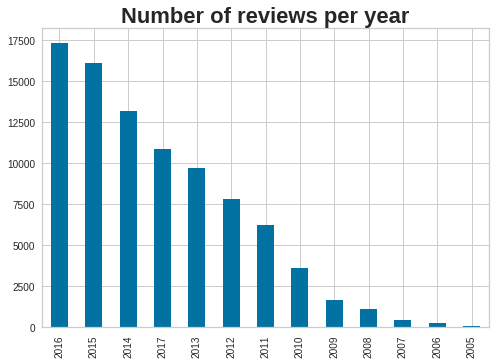

In [5]:
#number of reviews per year
rdf.year.value_counts().plot.bar()
plt.title('Number of reviews per year', weight='bold', size=22)
plt.show()

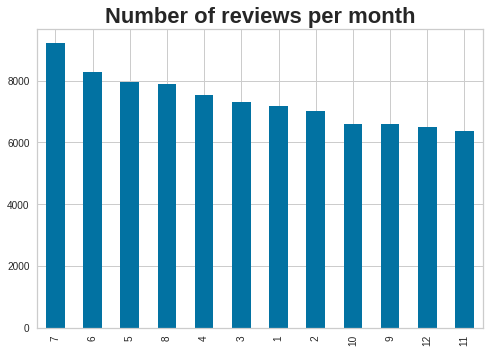

In [6]:
#number of reviews per month
rdf.month.value_counts().plot.bar()
plt.title('Number of reviews per month', weight='bold', size=22)
plt.show()

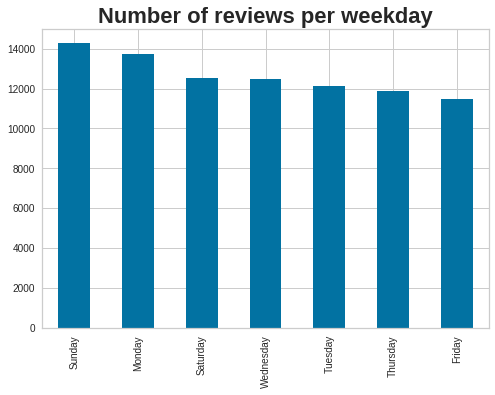

In [7]:
#number of reviews per weekday
rdf.weekday.value_counts().plot.bar()
plt.title('Number of reviews per weekday', weight='bold', size=22)
plt.show()

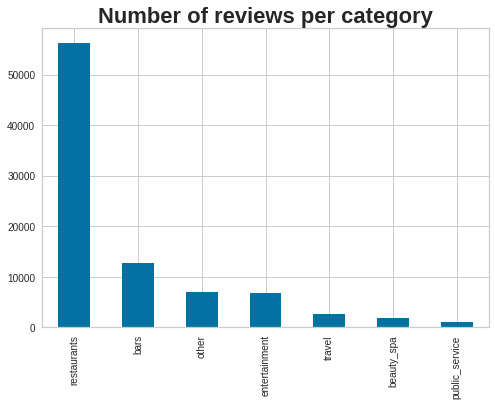

In [8]:
#number of reviews of each category
rdf.category.value_counts().plot.bar()
plt.title('Number of reviews per category', weight='bold', size=22)
plt.show()

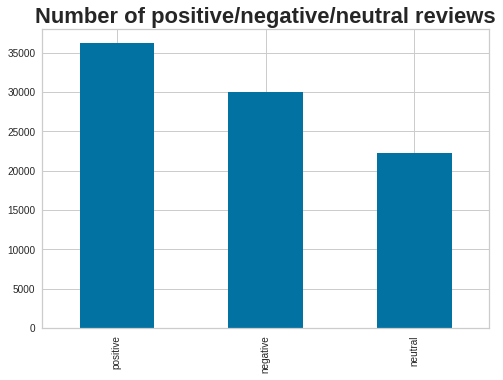

In [9]:
#number of positive/negative/neutral reviews
rdf.review.value_counts().plot.bar()
plt.title('Number of positive/negative/neutral reviews', weight='bold', size=22)
plt.show()

### Numeric Data



---

1. Overall info about all numeric data 
2. Star distrubution
3. Company star distribution
4. Open hours distribution
5. Close hours distribution

---



In [10]:
#Overall info about all numeric data 
rdf.describe()

,stars,year,month,company_star,company_review,is_open,accept_credit_card,mon_open,mon_close,tue_open,tue_close,wed_open,wed_close,thu_open,thu_close,fri_open,fri_close,sat_open,sat_close,sun_open,sun_close,park_garage,park_street,park_lot,park_valid,park_vallet,park_bike
count,88504.000000,88504.000000,88504.000000,88504.000000,88504.000000,88504.000000,88504.000000,88504.000000,88504.000000,88504.000000,88504.000000,88504.000000,88504.000000,88504.000000,88504.000000,88504.000000,88504.000000,88504.000000,88504.000000,88504.000000,88504.000000,88504.000000,88504.000000,88504.000000,88504.000000,88504.000000,88504.000000
mean,3.763152,2014.043851,6.374605,3.757678,157.703222,0.896163,0.846301,8.047749,11.484543,9.459674,13.458217,9.651767,13.687042,9.613961,13.351532,9.551817,11.848029,9.456454,11.264417,7.371317,10.821940,-0.044642,0.377667,0.133565,-0.122254,-0.010644,0.539851
std,1.342591,2.295412,3.331766,0.684571,186.432232,0.305051,0.510737,5.932281,10.258975,5.439730,9.806527,5.328815,9.725802,5.289566,9.792981,5.151634,10.106581,5.366215,10.115196,6.149109,10.179668,0.469450,0.708559,0.618664,0.360301,0.506223,0.779654
min,1.000000,2005.000000,1.000000,1.000000,3.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,3.000000,2013.000000,4.000000,3.500000,31.000000,1.000000,1.000000,0.000000,0.000000,7.000000,1.000000,7.000000,2.000000,7.000000,2.000000,7.000000,1.000000,8.000000,1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.000000,2015.000000,6.000000,4.000000,89.000000,1.000000,1.000000,10.000000,17.000000,11.000000,19.000000,11.000000,19.000000,11.000000,19.000000,11.000000,17.000000,11.000000,15.000000,10.000000,15.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,5.000000,2016.000000,9.000000,4.000000,205.000000,1.000000,1.000000,11.000000,22.000000,11.000000,22.000000,11.000000,22.000000,11.000000,22.000000,11.000000,22.000000,12.000000,22.000000,11.000000,21.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,5.000000,2017.000000,12.000000,5.000000,896.000000,1.000000,1.000000,22.000000,23.000000,22.000000,23.000000,22.000000,23.000000,22.000000,23.000000,22.000000,23.000000,23.000000,23.000000,22.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


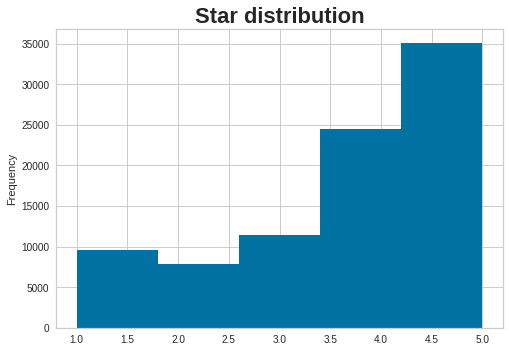

In [11]:
#star distribution
rdf.stars.plot.hist(bins=5)
plt.title('Star distribution', weight='bold', size=22)
plt.show()

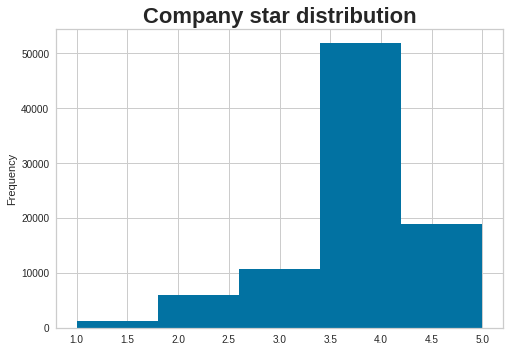

In [12]:
#company star distribution
rdf.company_star.plot.hist(bins=5)
plt.title('Company star distribution', weight='bold', size=22)
plt.show()

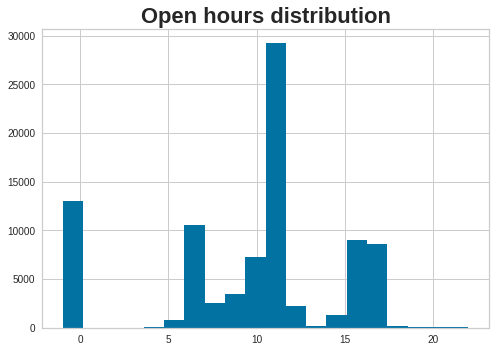

In [13]:
#open hours distribution
rdf.wed_open.hist(bins=20)
plt.title('Open hours distribution', weight='bold', size=22)
plt.show()

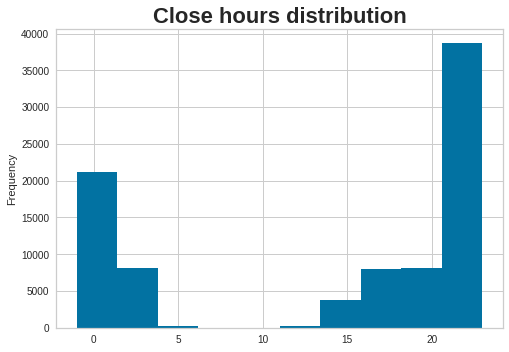

In [14]:
#close hours distribution
rdf.wed_close.plot.hist()
plt.title('Close hours distribution', weight='bold', size=22)
plt.show()

## Relationship 

### Correlation

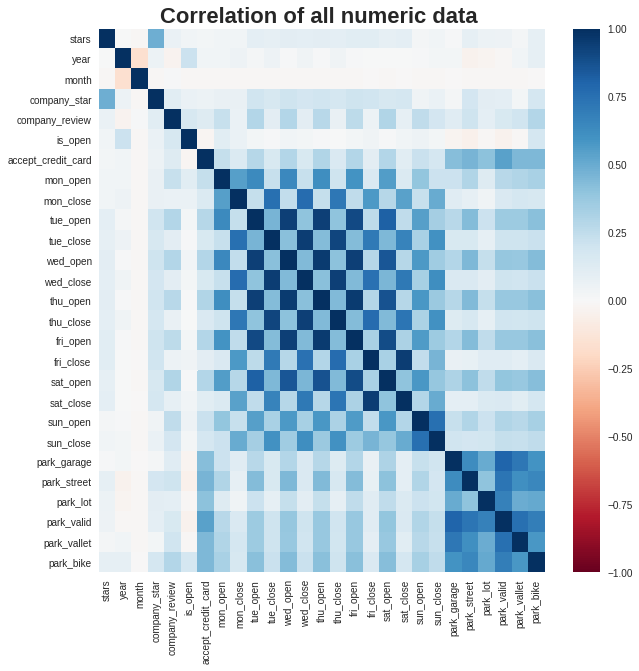

In [15]:
ax, fig = plt.subplots(figsize=(10,10))
sns.heatmap(rdf.corr(), cmap = 'RdBu', vmin = -1, vmax = 1)
plt.title('Correlation of all numeric data ', weight='bold', size=22)
plt.show()

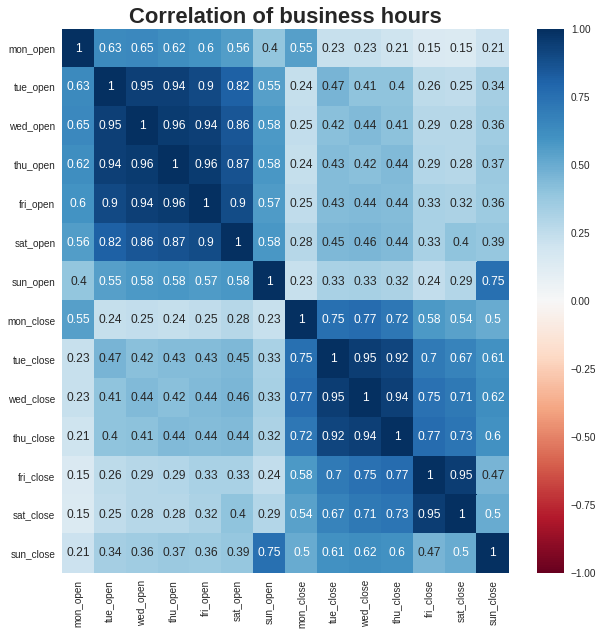

In [16]:
wdf = rdf[['mon_open', 'tue_open', 'wed_open',  'thu_open', 'fri_open', 'sat_open', 'sun_open',
           'mon_close', 'tue_close', 'wed_close', 'thu_close', 'fri_close', 'sat_close', 'sun_close']]
ax, fig = plt.subplots(figsize=(10,10))
sns.heatmap(wdf.corr(), vmax = 1, vmin=-1, annot=True, cmap='RdBu')
plt.title('Correlation of business hours', weight='bold', size=22)
plt.show()

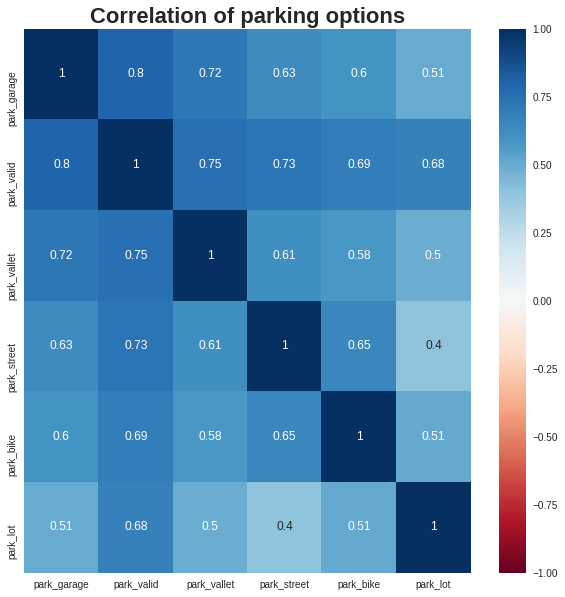

In [18]:
pdf = rdf[['park_garage', 'park_valid', 'park_vallet', 'park_street', 'park_bike', 'park_lot']]
ax, fig = plt.subplots(figsize=(10,10))
sns.heatmap(pdf.corr(), vmax = 1, vmin=-1, annot=True, cmap='RdBu')
plt.title('Correlation of parking options', weight='bold', size=22)
plt.show()

### Year vs Stars

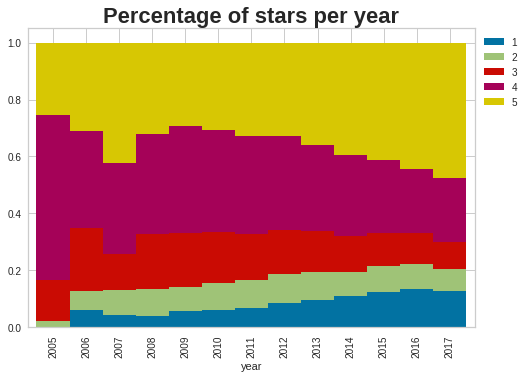

In [20]:
(rdf
 .pipe(lambda df_: pd.crosstab(df_.year, df_.stars))
 .pipe(lambda df_: df_.div(df_.sum(axis=1), axis=0))
 .plot.bar(stacked=True, width=1)
 .legend(bbox_to_anchor = (1,1)))
plt.title('Percentage of stars per year', weight='bold', size=22)
plt.show()

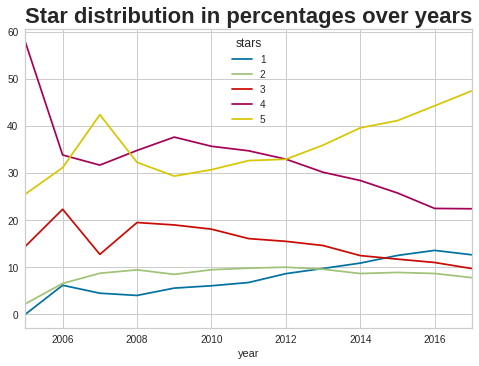

In [21]:
years_df = (rdf
                 .pipe(lambda df_: pd.crosstab(df_.year, df_.stars))
                 .pipe(lambda df_: df_.div(df_.sum(axis=1), axis=0))
                 .mul(100)
                 .reset_index()
                 )
fig, ax = plt.subplots()
years_df.plot(x = 'year', y = years_df.columns[1:], ax=ax)
plt.title('Star distribution in percentages over years', weight='bold', size=22)
plt.show()

### Month vs Stars

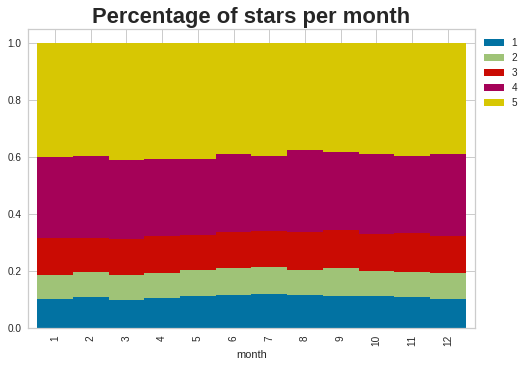

In [24]:
(rdf
 .pipe(lambda df_: pd.crosstab(df_.month, df_.stars))
 .pipe(lambda df_: df_.div(df_.sum(axis=1), axis=0))
 .plot.bar(stacked=True, width=1)
 .legend(bbox_to_anchor=(1,1))
 )
plt.title('Percentage of stars per month', weight='bold', size=22)
plt.show()

### Weekday vs Stars

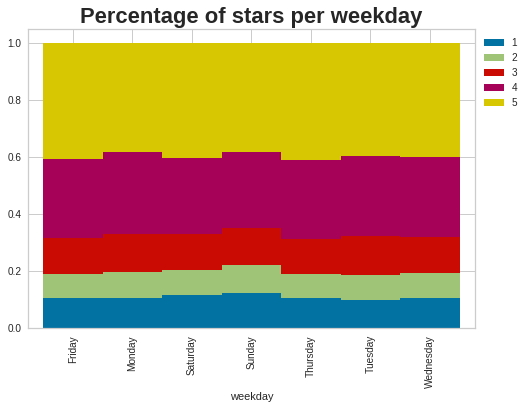

In [25]:
(rdf
 .pipe(lambda df_: pd.crosstab(df_.weekday, df_.stars))
 .pipe(lambda df_: df_.div(df_.sum(axis=1), axis=0))
 .plot.bar(stacked=True, width =1)
 .legend(bbox_to_anchor=(1,1)))
plt.title('Percentage of stars per weekday', weight='bold', size=22)
plt.show()

### Category vs Stars

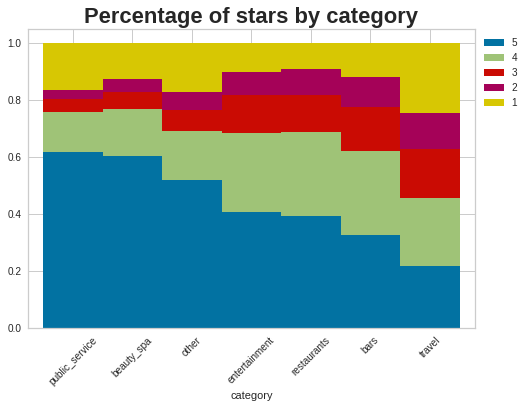

In [27]:
category = ['public_service', 'beauty_spa', 'other', 'entertainment', 'restaurants', 'bars', 'travel']
stars = [5,4,3,2,1]
(rdf
 .pipe(lambda df_: pd.crosstab(df_.category, df_.stars))
 .pipe(lambda df_: df_.div(df_.sum(axis=1), axis=0))
 .loc[category, stars]
 .plot.bar(stacked=True, width =1)
 .legend(bbox_to_anchor=(1,1)))
plt.title('Percentage of stars by category', weight='bold', size=22)
plt.xticks(rotation=45)
plt.show()

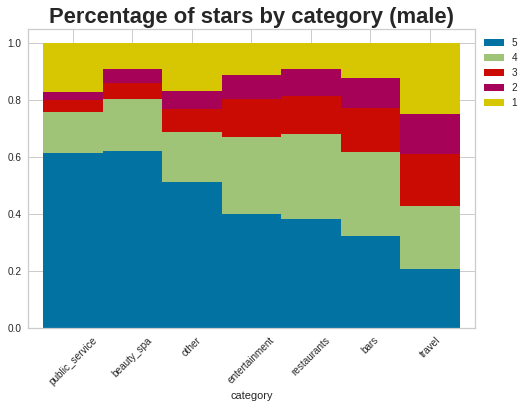

In [28]:
(rdf[rdf.user_gender=='male']
 .pipe(lambda df_: pd.crosstab(df_.category, df_.stars))
 .pipe(lambda df_: df_.div(df_.sum(axis=1), axis=0))
 .loc[category, stars]
 .plot.bar(stacked=True, width =1)
 .legend(bbox_to_anchor=(1,1)))
plt.title('Percentage of stars by category (male)', weight='bold', size=22)
plt.xticks(rotation=45)
plt.show()

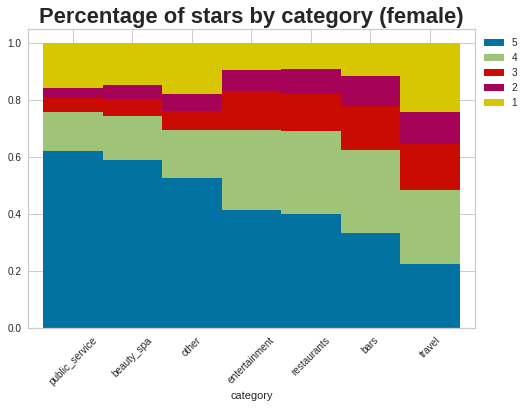

In [29]:
(rdf[rdf.user_gender=='female']
 .pipe(lambda df_: pd.crosstab(df_.category, df_.stars))
 .pipe(lambda df_: df_.div(df_.sum(axis=1), axis=0))
 .loc[category, stars]
 .plot.bar(stacked=True, width =1)
 .legend(bbox_to_anchor=(1,1)))
plt.title('Percentage of stars by category (female)', weight='bold', size=22)
plt.xticks(rotation=45)
plt.show()

### Open Hours vs Stars

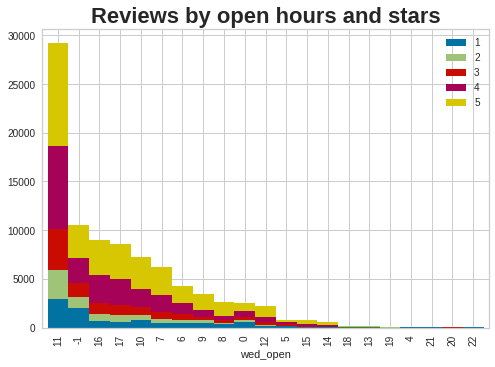

In [30]:
(rdf
 .pipe(lambda df_: pd.crosstab(df_.wed_open, df_.stars))
 .assign(sum = lambda df_: df_.sum(axis=1))
 .sort_values(by=['sum'], ascending = False)
 .loc[:,[1,2,3,4,5]]
 .plot.bar(stacked=True, width =1)
 .legend(bbox_to_anchor=(1,1)))
plt.title('Reviews by open hours and stars', weight='bold', size=22)
plt.show()

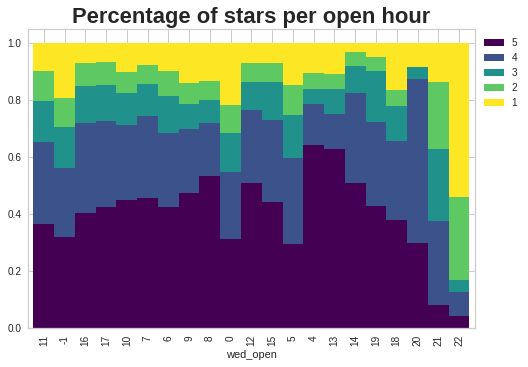

In [31]:
stars=[5,4,3,2,1]
(rdf
 .pipe(lambda df_: pd.crosstab(df_.wed_open, df_.stars))
 .pipe(lambda df_: df_.div(df_.sum(axis=1), axis=0))
 .assign(reviewbin = lambda df_: pd.cut(rdf.pipe(lambda df_: pd.crosstab(df_.wed_open, df_.stars)).sum(axis=1), bins=50, labels=[x for x in range(1, 51)]))
 .sort_values(by=['reviewbin', 5], ascending = False)
 .loc[:,[1,2,3,4,5]]
 .loc[:, stars]
 .plot.bar(stacked=True, width =1, cmap = 'viridis')
 .legend(bbox_to_anchor=(1,1))
 )
plt.title('Percentage of stars per open hour', weight='bold', size=22)
plt.show()

### Close Hours vs Stars

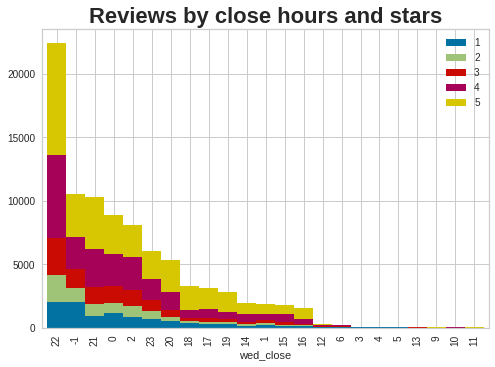

In [32]:
(rdf
 .pipe(lambda df_: pd.crosstab(df_.wed_close, df_.stars))
 .assign(sum = lambda df_: df_.sum(axis=1))
 .sort_values(by=['sum'], ascending = False)
 .loc[:,[1,2,3,4,5]]
 .plot.bar(stacked=True, width =1)
 .legend(bbox_to_anchor=(1,1)))
plt.title('Reviews by close hours and stars', weight='bold', size=22)
plt.show()

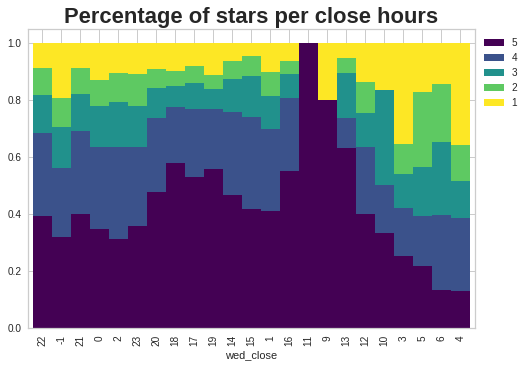

In [33]:
stars=[5,4,3,2,1]
(rdf
 .pipe(lambda df_: pd.crosstab(df_.wed_close, df_.stars))
 .pipe(lambda df_: df_.div(df_.sum(axis=1), axis=0))
 .assign(reviewbin = lambda df_: pd.cut(rdf.pipe(lambda df_: pd.crosstab(df_.wed_close, df_.stars)).sum(axis=1), bins=50, labels=[x for x in range(1, 51)]))
 .sort_values(by=['reviewbin', 5], ascending = False)
 .loc[:,[1,2,3,4,5]]
 .loc[:, stars]
 .plot.bar(stacked=True, width =1, cmap = 'viridis')
 .legend(bbox_to_anchor=(1,1))
 )
plt.title('Percentage of stars per close hours', weight='bold', size=22)
plt.show()

### Review vs Stars

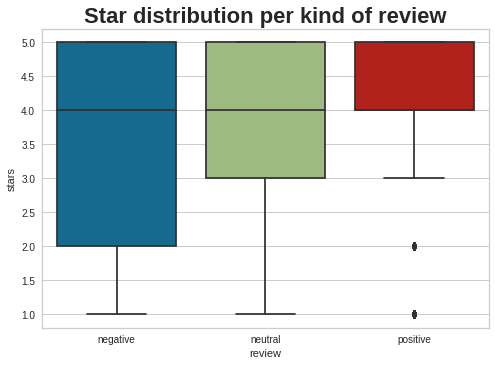

In [34]:
sns.boxplot(x = 'review', y = 'stars', data = rdf)
plt.title('Star distribution per kind of review', weight='bold', size=22)
plt.show()

### Company Stars vs Stars

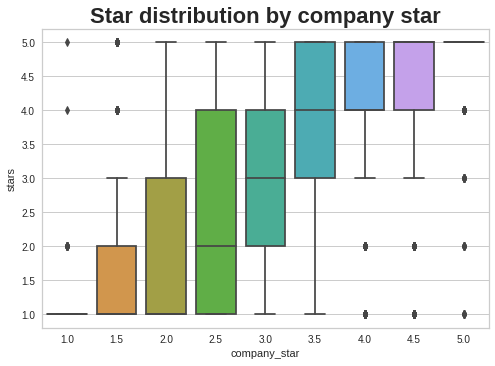

In [35]:
sns.boxplot(x='company_star', y='stars', data = rdf)
plt.title('Star distribution by company star', weight='bold', size=22)
plt.show()

### Parking vs Stars

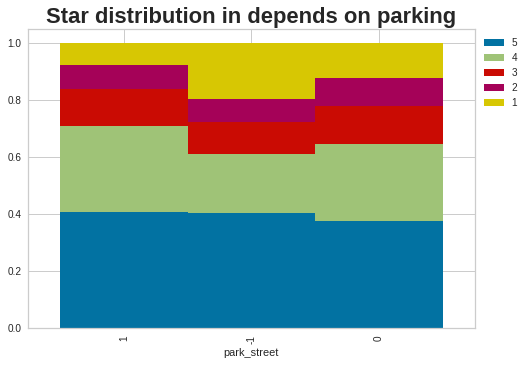

In [36]:
park =[1, -1, 0]
stars=[5,4,3,2,1]
(rdf
 .pipe(lambda df_: pd.crosstab(df_.park_street, df_.stars))
 .pipe(lambda df_: df_.div(df_.sum(axis=1), axis=0))
 .loc[park, stars]
 .plot.bar(stacked=True, width=1)
 .legend(bbox_to_anchor=(1,1))
 )
plt.title('Star distribution in depends on parking', weight='bold', size=22)
plt.show()

### Company Star vs Open

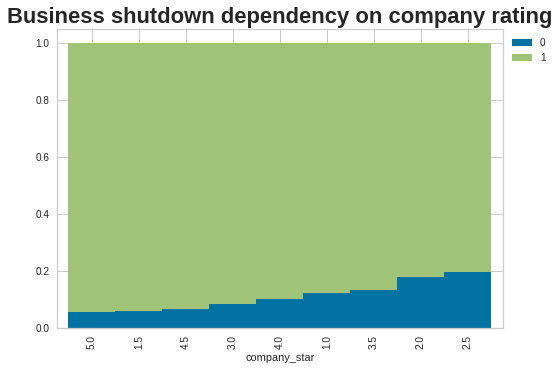

In [37]:
stars = [5.0, 1.5, 4.5, 3.0, 4.0, 1.0, 3.5, 2.0, 2.5]
(rdf
 .pipe(lambda df_: pd.crosstab(df_.company_star, df_.is_open))
 .pipe(lambda df_: df_.div(df_.sum(axis=1), axis=0))
 .loc[stars]
 .plot.bar(stacked=True, width =1)
 .legend(bbox_to_anchor=(1,1)))
plt.title('Business shutdown dependency on company rating', weight='bold', size=22)
plt.show()

### Company Review vs Open

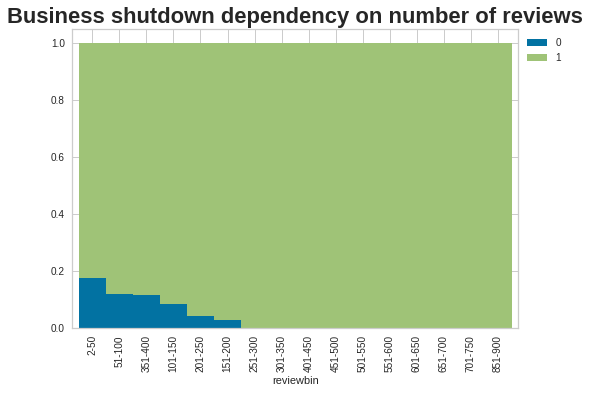

In [38]:
labels = ['2-50', '51-100', '101-150', '151-200', '201-250', '251-300', '301-350', '351-400', '401-450', 
          '451-500', '501-550','551-600','601-650', '651-700', '701-750', '751-800', '801-850', '851-900']
reviewbin = ['2-50', '51-100', '351-400', '101-150', '201-250', '151-200', '251-300', '301-350', 
             '401-450', '451-500', '501-550','551-600','601-650', '651-700', '701-750', '851-900']
(rdf
 .assign(reviewbin=pd.cut(rdf.company_review, bins=18, labels=labels))
 .pipe(lambda df_: pd.crosstab(df_.reviewbin, df_.is_open))
 .pipe(lambda df_: df_.div(df_.sum(axis=1), axis=0))
 .loc[reviewbin]
 .plot.bar(stacked=True, width =1)
 .legend(bbox_to_anchor=(1,1)))
plt.title('Business shutdown dependency on number of reviews', weight='bold', size=22)
plt.show()

## Conclusions



---



1. business hours for each days are correlated, so we can use 1 day for analysis: wednesday (as long as it has the biggest correlation with all other days) and drop all other business hour columns
2. all parking options are correlated, so we can use 1 column for analysis: park_street (as long as it has the smalest number of missing values) and drop all other parking columns
3. The amount of reviews per each month is simillar and percentages of stars don't really change from month to month => Feature doesn't have lot's info
4. The amount of reviews per each day is simillar and percentages of stars don't really change from day to day => Feature doesn't have lot's info



---



In [0]:
rdf = (rdf
         .assign(open_hours=rdf.wed_open)
         .assign(close_hours=rdf.wed_close)
         .assign(parking=rdf.park_street)
         .drop(['mon_open', 'mon_close', 'tue_open', 'tue_close', 'sat_open', 
                'sat_close', 'thu_open', 'thu_close', 'fri_open', 'fri_close', 
                'sun_open', 'sun_close', 'wed_open', 'wed_close', 'park_garage',
                'park_street', 'park_lot', 'park_valid', 'park_vallet', 
                'park_bike','month', 'weekday'], axis=1))

# Plotting

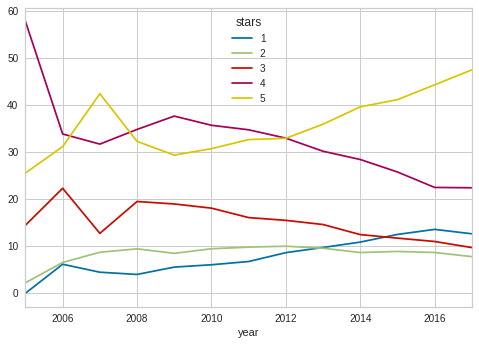

In [40]:
years_df = (rdf
                 .pipe(lambda df_: pd.crosstab(df_.year, df_.stars))
                 .pipe(lambda df_: df_.div(df_.sum(axis=1), axis=0))
                 .mul(100)
                 .reset_index()
                 )

fig, ax = plt.subplots()
years_df.plot(x = 'year', y = years_df.columns[1:], ax=ax)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


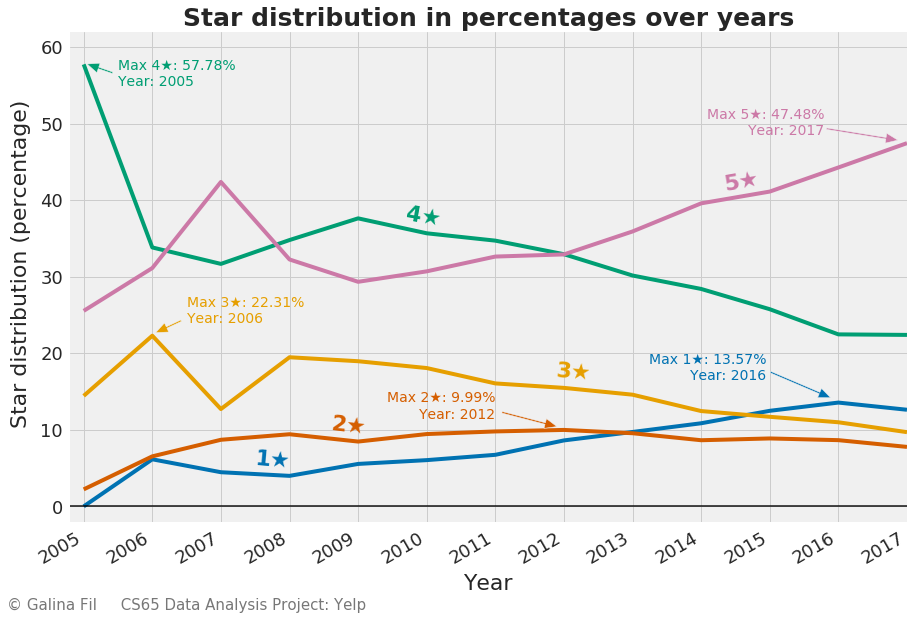

In [41]:
matplotlib.rcParams['font.sans-serif'] = ['Source Han Sans TW', 'sans-serif']

fig1, ax = plt.subplots(figsize=(15,10))

max_val, max_year = [], []
for i in range(1,6):
  max_val.append(max(years_df[i]))
  max_year.append(years_df.year.iloc[years_df[i].idxmax()])

with plt.style.context('fivethirtyeight'):
  #colorblinf-friendly colors
  colors = [[0,114/255,178/255], [213/255,94/255,0], [230/255,159/255,0], [0,158/255,115/255], [204/255,121/255,167/255]]

  #lineplots
  years_df.plot(x = 'year', y = years_df.columns[1:], ax=ax, legend = False, color=colors)

  #axes params
  ax.set_xlim(2004.8, 2016.2)
  ax.set_xticks(years_df.year)
  ax.set_ylim(-2, 62)
  ax.tick_params(axis='both', which='major', labelsize=18, color='#777777')
  plt.xlabel('')
  fig1.autofmt_xdate()

  #axes style
  ax.set_facecolor('#F0f0f0')
  ax.spines['top'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.axhline(y=0, color='black', alpha=0.7, linewidth=2)

  #axes labels, title
  ax.text(-0.07, 0.20, 'Star distribution (percentage)', rotation = 90, transform=ax.transAxes, size=22)
  ax.text(0.47, -0.14, 'Year', transform=ax.transAxes, size=22)
  ax.set_title('Star distribution in percentages over years', weight='bold', size=25)
  ax.text(x=-0.075, y=-0.18, s="""© Galina Fil     CS65 Data Analysis Project: Yelp""", fontsize=15, color='#777777', transform=ax.transAxes)
  
  #5★ annotation
  ax.text(0.78, 0.675, '5★',transform=ax.transAxes, rotation = 10, size=22, color=colors[4], weight='bold')
  ax.annotate(f'Max 5★: {max_val[4]:.2f}%\nYear: {max_year[4]}', xy = (2015.8, 48.5), color=colors[4], ha='right')
  purple_arrow_properties = dict(facecolor=colors[4], width=1.5, headwidth=10, shrink=0.1)
  ax.annotate(' ', xy=(max_year[4], max_val[4]+0.2), xytext=(2015.6, 50), arrowprops=purple_arrow_properties)

  #4★ annotation
  ax.text(0.4, 0.605, '4★', transform=ax.transAxes, rotation = -10, size=22, color=colors[3], weight='bold')
  ax.annotate(f'Max 4★: {max_val[3]:.2f}%\nYear: {max_year[3]}', xy = (2005.5, 55), color=colors[3], ha='left')
  red_arrow_properties = dict(facecolor=colors[3], width=1.5, headwidth=10, shrink=0.1)
  ax.annotate(' ', xy=(max_year[3], max_val[3]+0.2), xytext=(2005.5, 55), arrowprops=red_arrow_properties)
  
  #3★ annotation
  ax.text(0.58, 0.29, '3★', transform=ax.transAxes, rotation = -5, size=22, color=colors[2], weight='bold')
  ax.annotate(f'Max 3★: {max_val[2]:.2f}%\nYear: {max_year[2]}', xy = (2006.5, 24), color=colors[2], ha='left')
  green_arrow_properties = dict(facecolor=colors[2], width=1.5, headwidth=10, shrink=0.1)
  ax.annotate(' ', xy=(max_year[2], max_val[2]+0.2), xytext=(2006.5, 25), arrowprops=green_arrow_properties)

  #2★ annotation
  ax.text(0.31, 0.18, '2★', transform=ax.transAxes, rotation = -7, size=22, color=colors[1], weight='bold')
  ax.annotate(f'Max 2★: {max_val[1]:.2f}%\nYear: {max_year[1]}', xy = (2011, 11.5), color=colors[1], ha='right')
  orange_arrow_properties = dict(facecolor=colors[1], width=1.5, headwidth=10, shrink=0.1)
  ax.annotate(' ', xy=(max_year[1], max_val[1]+0.2), xytext=(2010.9, 13), arrowprops=orange_arrow_properties)

  #1★ annotation
  ax.text(0.22, 0.11, '1★', transform=ax.transAxes, rotation = -5, size=22, color=colors[0], weight='bold')
  ax.annotate(f'Max 1★: {max_val[0]:.2f}%\nYear: {max_year[0]}', xy = (2014.95, 16.5), color=colors[0], ha='right')
  blue_arrow_properties = dict(facecolor=colors[0], width=1.5, headwidth=10, shrink=0.1)
  ax.annotate(' ', xy=(max_year[0], max_val[0]+0.2), xytext=(2014.8, 18.5), arrowprops=blue_arrow_properties)

plt.show()

# Machine Learning

## Data Preparation



---
Before using any of ML machanism we need to:
1. Get rid of categorical data
2. Check for missing value
3. Check that all data is numeric

---



In [0]:
#get rid of categorical data
def no_cat(df):
  df = pd.get_dummies(df)
  cols = [col.replace(' ','_') for col in df.columns]
  df.columns = cols
  return df

ml_df = no_cat(rdf)

In [43]:
#check if there are missing values
ml_df.isna().mean()

stars                      0.0
year                       0.0
company_star               0.0
company_review             0.0
is_open                    0.0
accept_credit_card         0.0
open_hours                 0.0
close_hours                0.0
parking                    0.0
review_negative            0.0
review_neutral             0.0
review_positive            0.0
user_gender_female         0.0
user_gender_male           0.0
category_bars              0.0
category_beauty_spa        0.0
category_entertainment     0.0
category_other             0.0
category_public_service    0.0
category_restaurants       0.0
category_travel            0.0
dtype: float64

In [44]:
#check data types
ml_df.dtypes

stars                        int64
year                         int64
company_star               float64
company_review               int64
is_open                      int64
accept_credit_card           int64
open_hours                   int64
close_hours                  int64
parking                      int64
review_negative              uint8
review_neutral               uint8
review_positive              uint8
user_gender_female           uint8
user_gender_male             uint8
category_bars                uint8
category_beauty_spa          uint8
category_entertainment       uint8
category_other               uint8
category_public_service      uint8
category_restaurants         uint8
category_travel              uint8
dtype: object

## Data Standartization



---

As long as different data has different variance in absolute numbers, we need to standartize every column to be able to compare it between each other.

**Standartized data**:
* mean = 0
* standart deviation  = 1




---



In [61]:
#stadartize data
X = ml_df
std = preprocessing.StandardScaler()
X_std = pd.DataFrame(std.fit_transform(X), columns=X.columns)
X_std.head()

,stars,year,company_star,company_review,is_open,accept_credit_card,open_hours,close_hours,parking,review_negative,review_neutral,review_positive,user_gender_female,user_gender_male,category_bars,category_beauty_spa,category_entertainment,category_other,category_public_service,category_restaurants,category_travel
0,-1.313253,-0.454758,-1.106799,-0.019864,0.340395,0.300938,0.253009,0.751917,-0.533009,1.395768,-0.579560,-0.832533,-1.073737,1.073737,-0.410798,-0.147159,-0.286857,-0.291148,-0.115745,0.756072,-0.1781
1,-1.313253,-2.197375,-1.106799,-0.019864,0.340395,0.300938,0.253009,0.751917,-0.533009,1.395768,-0.579560,-0.832533,-1.073737,1.073737,-0.410798,-0.147159,-0.286857,-0.291148,-0.115745,0.756072,-0.1781
2,-2.058086,0.416550,-1.106799,-0.019864,0.340395,0.300938,0.253009,0.751917,-0.533009,-0.716452,1.725448,-0.832533,0.931327,-0.931327,-0.410798,-0.147159,-0.286857,-0.291148,-0.115745,0.756072,-0.1781
3,0.176412,0.416550,-1.106799,-0.019864,0.340395,0.300938,0.253009,0.751917,-0.533009,-0.716452,-0.579560,1.201154,-1.073737,1.073737,-0.410798,-0.147159,-0.286857,-0.291148,-0.115745,0.756072,-0.1781
4,-0.568420,-0.890412,-1.106799,-0.813722,0.340395,0.300938,-1.998911,-1.510120,-0.533009,-0.716452,1.725448,-0.832533,-1.073737,1.073737,-0.410798,-0.147159,-0.286857,-0.291148,-0.115745,0.756072,-0.1781


In [46]:
#mean=0
X_std.mean()

stars                      1.570378e-14
year                       9.167702e-15
company_star               3.414092e-14
company_review             7.541579e-15
is_open                    1.440898e-13
accept_credit_card         5.672354e-14
open_hours                -2.806803e-14
close_hours               -4.653495e-14
parking                    5.799539e-14
review_negative            1.451838e-15
review_neutral             1.809446e-15
review_positive           -3.096692e-15
user_gender_female        -2.498780e-16
user_gender_male           2.516843e-16
category_bars              6.888653e-15
category_beauty_spa       -4.645415e-16
category_entertainment    -2.831982e-14
category_other            -9.461784e-15
category_public_service   -4.888006e-14
category_restaurants       1.902679e-14
category_travel            3.120297e-14
dtype: float64

In [47]:
#std=1
X_std.std()

stars                      1.000006
year                       1.000006
company_star               1.000006
company_review             1.000006
is_open                    1.000006
accept_credit_card         1.000006
open_hours                 1.000006
close_hours                1.000006
parking                    1.000006
review_negative            1.000006
review_neutral             1.000006
review_positive            1.000006
user_gender_female         1.000006
user_gender_male           1.000006
category_bars              1.000006
category_beauty_spa        1.000006
category_entertainment     1.000006
category_other             1.000006
category_public_service    1.000006
category_restaurants       1.000006
category_travel            1.000006
dtype: float64

## Principal Component Analysis



---

Machine learning mechanisms work as better as more information we give to them, but at the same time they work much slower if they got too many features

**Goal:** reduce dimensionality of data with keeping as much variance as possible

**Solution:** Principal Component Analysis (PCA)

---




### PCA Model



---

To analyze which features have the most variance I need: 
1. to build PCA model out of standartized data I've just got
2. to have a look on percentage of variance of original data each PC represents

---



In [62]:
#pca model
pca = decomposition.PCA()
pca_X = pd.DataFrame(pca.fit_transform(X_std), columns=(f'PC{i+1}' for i in range(len(X.columns))))
pca_X.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
0,0.129561,-2.293763,-1.356863,-1.022833,-0.417535,0.973854,-0.089615,-0.246600,0.159591,-0.117147,0.428483,-0.591535,-0.168123,-0.493836,0.115239,-0.421560,-0.282107,0.248164,-2.824750e-14,-4.746905e-14,-2.257271e-14
1,0.147020,-2.414256,-1.439398,-1.125555,-0.690992,0.639123,0.376733,0.717994,0.417835,-0.078398,0.003011,-1.315123,-0.773710,-1.199399,0.124345,-0.408114,-0.455610,0.293557,6.136168e-16,-8.488073e-15,-9.577754e-15
2,-0.130178,0.559295,-1.774153,-1.035969,1.531674,-0.927565,-0.612688,-1.010469,0.355227,-0.475381,1.505158,-1.107827,-0.191070,0.038757,0.022419,0.221855,-0.701711,0.261870,1.441873e-15,7.270685e-15,-4.915891e-15
3,-0.606956,-1.166063,1.117166,-0.763502,-1.084489,-0.186951,-0.735601,-0.910841,0.143196,-0.256938,0.843682,-0.400416,0.055834,-0.208700,0.166174,-0.908073,0.284755,0.206011,-6.597747e-16,-1.641007e-15,-1.727295e-15
4,1.429193,-1.832305,-0.038052,-1.009545,1.205848,-2.312601,-0.145185,-0.004072,-0.435584,-0.116974,0.235611,0.573404,-1.711400,-0.533305,0.003228,-0.329632,-0.280188,0.036050,3.290491e-16,1.905553e-15,-2.855836e-17


In [63]:
#how much of all the varience of the df is in each PC: PC1 14%
pca.explained_variance_ratio_

array([1.40265192e-01, 9.63241304e-02, 9.08616870e-02, 7.63252011e-02,
       6.86049794e-02, 6.40235652e-02, 5.98594344e-02, 5.52202179e-02,
       5.07571326e-02, 4.94740115e-02, 4.61878826e-02, 4.45948755e-02,
       3.74017324e-02, 3.10812525e-02, 2.65939944e-02, 2.40937457e-02,
       2.11903714e-02, 1.71405943e-02, 1.16942728e-32, 4.69455520e-33,
       3.21852699e-33])

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


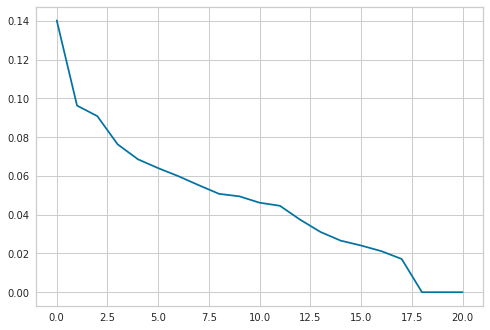

In [50]:
plt.plot(pca.explained_variance_ratio_)



---

**Conclusion:** 


*   PC1: 14%
*   PC2: 9.6%
*   PC3: 9%
*   PC4: 7.6% etc



---



### Components



---

As long as PCA model is built such way that each next PC has less variance that previous one, we can consider first 4 PCs to make conclusions about the feature with most variance.

The best way to see which column influents on particular component is **visualization**:


1.   *Barplot:* to have an overlook on influence of all columns on each of 4 PCs we are dealing with and choose the most affecting ones
2.   *Scatterplot:* to see the spread of choosen column over PCx-axes and PCy-axes (or both) using coloring  



---



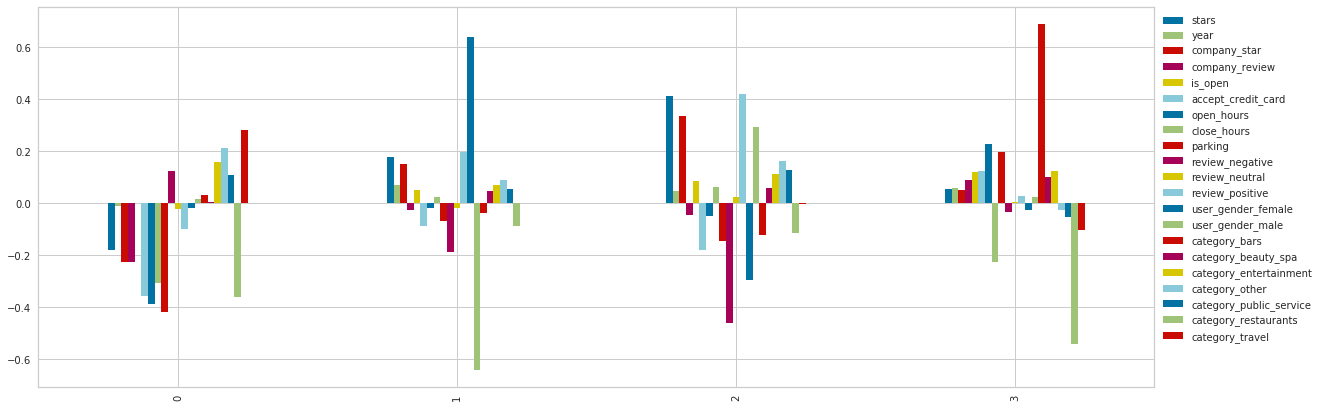

In [64]:
(pd.DataFrame(pca.components_, columns=X.columns)
.iloc[:4]
.plot.bar(figsize=(20,7))
.legend(bbox_to_anchor=(1,1)))

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


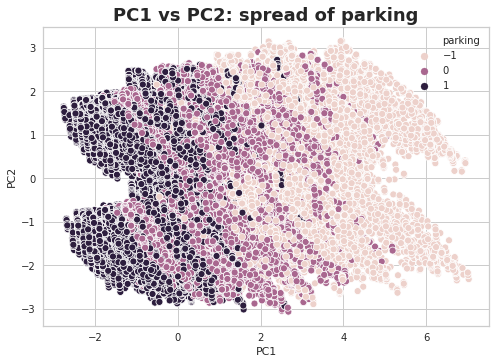

In [69]:
#PC1: spread of parking
sns.scatterplot(x='PC1', y='PC2', data = pca_X.assign(parking=X.parking), hue='parking')
plt.title('PC1 vs PC2: spread of parking', weight='bold', size=18)
plt.show()

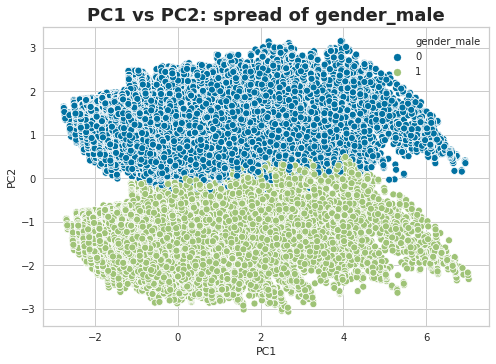

In [70]:
#PC2: spread of gender_male
sns.scatterplot(x='PC1', y='PC2', data = pca_X.assign(gender_male=X.user_gender_male), hue='gender_male')
plt.title('PC1 vs PC2: spread of gender_male', weight='bold', size=18)
plt.show()

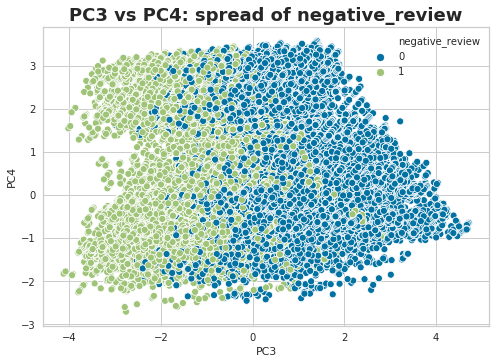

In [71]:
#PC3: spread of review_negative
sns.scatterplot(x='PC3', y='PC4', data = pca_X.assign(negative_review=X.review_negative), hue='negative_review')
plt.title('PC3 vs PC4: spread of negative_review', weight='bold', size=18)
plt.show()

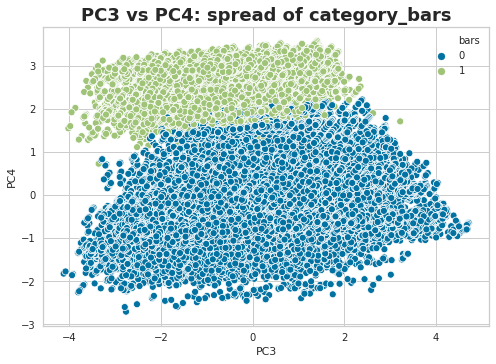

In [72]:
#PC4: spread of category_bars
sns.scatterplot(x='PC3', y='PC4', data = pca_X.assign(bars=X.category_bars), hue='bars')
plt.title('PC3 vs PC4: spread of category_bars', weight='bold', size=18)
plt.show()

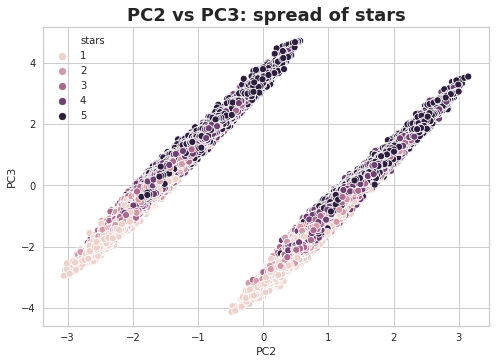

In [73]:
#PC3&PC2: spread of stars
sns.scatterplot(x='PC2', y='PC3', data = pca_X.assign(stars=X.stars), hue='stars', palette=sns.cubehelix_palette(5))
plt.title('PC2 vs PC3: spread of stars', weight='bold', size=18)
plt.show()



---

**Conclusion:** the columns that gives us the most variance:


1.   *parking* (PC1)
2.   *gender_male* (PC2)
3.   *review_negative* (PC3)
4.   *category_bars* (PC4)
5.   *stars* (PC3 & PC2)




---



## Clusterings



---

**Goal:** divide data to groups with similar samples to analyse


---



### Determining number of clusters



---

Before using clusters for analyzing data we need to decide how many clusters we should make. There are some methods to do it, I will use 3 of them, compare the results and make the decision about number of clusters:

1. enertia method
2. SilhouetteVisualizer method (takes time, ~40mins)
3. Hierartical method (colab doesn't have enough RAM for processing all data, so I took a sample of 50000 rows instead)

---



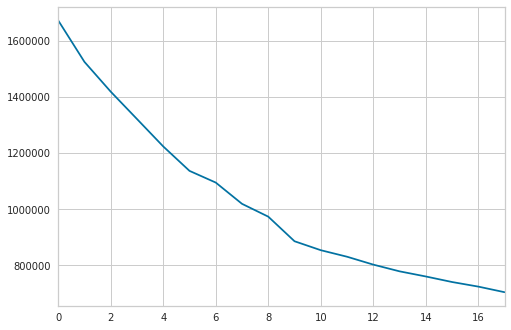

In [75]:
#inertia method
inerts = []

for i in range (2, 20):
  k = cluster.KMeans(n_clusters = i, random_state=42)
  k.fit(X_std)
  inerts.append(k.inertia_)

pd.Series(inerts).plot()

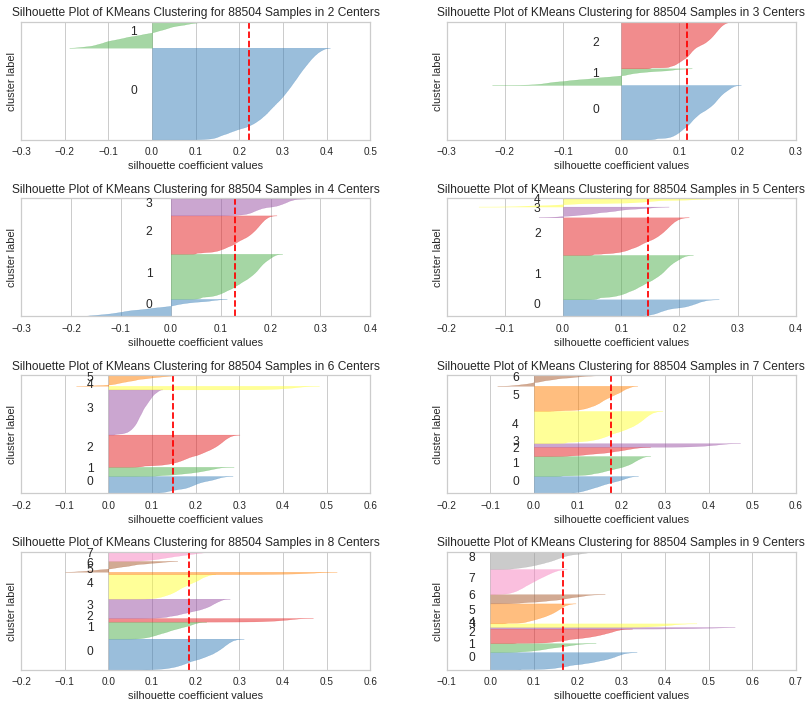

In [14]:
#SilhouetteVisualizer
start, end = 2, 10
cols = 2
rows = (end-start)//cols
fix, axes = plt.subplots(rows, cols, figsize=(12, 10))
axes = axes.reshape(cols*rows)
for i, k in enumerate(range(start, end), 0):
  ax = axes[i]
  sil = SilhouetteVisualizer(cluster.KMeans(n_clusters=k, random_state=42), ax=ax)
  sil.fit(X_std)
  sil.finalize()

plt.tight_layout()


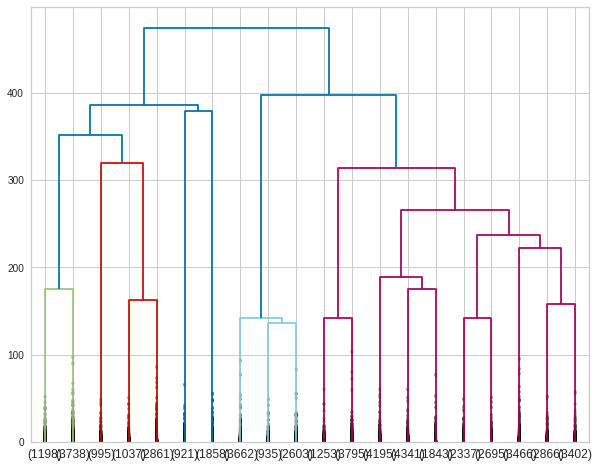

In [7]:
#hierartical clustering
fig, ax = plt.subplots(figsize=(10,8))
hierarchy.dendrogram(hierarchy.linkage(X_std.loc[:50000], method='ward'),
                     truncate_mode='lastp', p=20, show_contracted=True)
pass



---
**Conclutions:**
1. enertia plot bends the most around 6. And as long as it starts calculating from 2 custers => optimal number of clusters is 8
2. the average Silhouette coifficient is the highest at 2 and 8 centers. 2 centers option is not suitable because it's way too skewed (there are too many negative values in it) =>  optimal number of clusters is 8
3. if we slice the tallest lines on dendrogram (at ~300) we are going to cut 10 lines => optimal number of clusters is 8

---



### Using clusters for analysis

In [0]:
k7 = cluster.KMeans(n_clusters=8, random_state=42)
k7.fit(X_std)
labels = k7.predict(X_std)

In [77]:
(X.
 assign(label=labels)
 .groupby('label')
 .agg(['mean', 'std'])
 .T)

label                                   0  ...            7
stars                   mean     4.032607  ...     4.074094
                        std      1.131677  ...     1.404507
year                    mean  2013.968702  ...  2014.244136
                        std      2.304263  ...     2.189452
company_star            mean     3.835998  ...     4.091684
                        std      0.562827  ...     0.824696
company_review          mean   182.450578  ...    90.144989
                        std    205.097403  ...   136.814000
is_open                 mean     0.881238  ...     0.919510
                        std      0.323517  ...     0.272123
accept_credit_card      mean     0.967166  ...     0.885394
                        std      0.196436  ...     0.382525
open_hours              mean    10.315484  ...     8.646588
                        std      4.746648  ...     3.999779
close_hours             mean    16.197519  ...    15.753731
                        std      8.637440  ...     6.974935
parking                 mean     0.550788  ...     0.578891
                        std      0.543777  ...     0.570064
review_negative         mean     0.000000  ...     0.309168
                        std      0.000000  ...     0.462274
review_neutral          mean     0.391624  ...     0.254797
                        std      0.488127  ...     0.435863
review_positive         mean     0.608376  ...     0.436034
                        std      0.488127  ...     0.496024
user_gender_female      mean     0.000000  ...     0.581023
                        std      0.000000  ...     0.493523
user_gender_male        mean     1.000000  ...     0.418977
                        std      0.000000  ...     0.493523
category_bars           mean     0.000000  ...     0.000000
                        std      0.000000  ...     0.000000
category_beauty_spa     mean     0.000000  ...     1.000000
                        std      0.000000  ...     0.000000
category_entertainment  mean     0.000000  ...     0.000000
                        std      0.000000  ...     0.000000
category_other          mean     0.000000  ...     0.000000
                        std      0.000000  ...     0.000000
category_public_service mean     0.000000  ...     0.000000
                        std      0.000000  ...     0.000000
category_restaurants    mean     1.000000  ...     0.000000
                        std      0.000000  ...     0.000000
category_travel         mean     0.000000  ...     0.000000
                        std      0.000000  ...     0.000000

[42 rows x 8 columns]

In [79]:
(X.
 assign(label=labels)
 .groupby('label')
 .agg('mean')
 .T
 .style.background_gradient(cmap='RdBu', axis=1))

label,0,1,2,3,4,5,6,7
stars,4.03261,3.80931,3.29235,3.82762,3.60355,3.05623,4.01795,4.07409
year,2013.97,2014.02,2013.83,2014.1,2014.15,2014.08,2014.14,2014.24
company_star,3.836,3.80883,3.6864,3.80625,3.60708,3.0362,4.07821,4.09168
company_review,182.451,73.7893,178.324,182.514,164.28,127.426,74.1043,90.145
is_open,0.881238,0.940344,0.871448,0.878036,0.902748,0.975009,0.967521,0.91951
accept_credit_card,0.967166,0.444952,0.955807,0.971934,0.980189,0.0826902,-0.111966,0.885394
open_hours,10.3155,6.89986,10.0904,10.3816,11.9227,0.945241,6.65299,8.64659
close_hours,16.1975,11.377,15.2149,16.1349,8.12004,1.67181,13.9359,15.7537
parking,0.550788,-0.228081,0.520586,0.559878,0.62963,-0.986402,-0.849573,0.578891
review_negative,0,0.342674,1,0.322339,0.365516,0.425579,0.335897,0.309168




---

**Conclusion:** clusters I got:
*   0: positive and neutral male high-rated reviews about restaurants with late close hours and acceptance of credit card
*   1: reviews about intertainment and other categories
*   2: male low-rated negative reviews about restaurants with acceptance of credit card
*   3: female reviews about restaurants with late close hours and acceptance of credit card
*   4: reviews about bars with parking, late open hours and acceptance of credit card
*   5: low-rated reviews about open travel companies
*   6: high-rated reviews about public services
*   7: high-rated reviews about beauty salons & spa with parking and late close hours

---



# Summary

After making analysis of Yelp Dataset I found out:
  1. percentages of 5-star and 1-star ratings are rising over years, when diversity is decresing
  2. there is nearly no influence of season on star rating, although there is a bit more activity at summer time
  3. there is nearly no influence of weekday on star rating, although there is a bit more activity on Sundays and Mondays
  4. the most rated business is restaurants, when the most high-rated business are beauty salon & spa and public services, and most low-rated - travel (apparently because of airports)
  5. there is high correlation between business hours of different days and between different parking options as well
  6. majority of high rated companies open at about noon and close at 10-11pm
  7. business with rating 2.5-star has the biggest percentage of shutdowns
  8. majority of closed companies have little number of reviews
  9. there is nearly no difference between male and female star rating distribution, but men rate beauty salons & spa lightly higher than women
  10. companies with street parking option have the highest star-rating
  11. PCA showed the columns that gives us the most variance:
   * parking
   * gender_male
   * review_negative
   * category_bars
   * stars

  12. Clustering mechanism showed that data can be divided into 8 clusters:
*   0: positive and neutral male high-rated reviews about restaurants with late close hours and acceptance of credit card
*   1: reviews about intertainment and other categories
*   2: male low-rated negative reviews about restaurants with acceptance of credit card
*   3: female reviews about restaurants with late close hours and acceptance of credit card
*   4: reviews about bars with parking, late open hours and acceptance of credit card
*   5: low-rated reviews about open travel companies
*   6: high-rated reviews about public services
*   7: high-rated reviews about beauty salons & spa with parking and late close hours




